In [1]:
!nvidia-smi

Thu Mar 17 14:30:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    On   | 00000000:19:00.0 Off |                  N/A |
| 30%   31C    P8    17W / 350W |      5MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    On   | 00000000:1A:00.0 Off |                  N/A |
| 30%   

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


### 모델 이해하기

#### 첫번째 표기 방법
합성곱(nn.Cov2d) + 활성화 함수(nn.ReLU)를 하나의 합성곱 층으로 보고, 맥스풀링(nn.MaxPoold2d)은 풀링 층으로 별도로 명명  
  
#### 두번째 표기 방법
합성곱(nn.Conv2d) + 활성화 함수(nn.ReLU) + 맥스풀링(nn.MaxPoold2d)을 하나의 합성곱 층으로 간주

### 모델 구현

#### 필요한 도구 임포트, 입력 정의

In [4]:
import torch
import torch.nn as nn

In [5]:
# 배치 크기 × 채널 × 높이(height) × 너비(widht)의 크기의 텐서를 선언
inputs = torch.Tensor(1, 1, 28, 28)
print('텐서의 크기 : {}'.format(inputs.shape))

텐서의 크기 : torch.Size([1, 1, 28, 28])


#### 합성곱층과 풀링 선언

In [6]:
# 1채널 짜리를 입력받아서 32채널을 뽑아내는데 커널 사이즈는 3이고 패딩은 1
conv1 = nn.Conv2d(1, 32, 3, padding=1)
print(conv1)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [7]:
# 32채널 짜리를 입력받아서 64채널을 뽑아내는데 커널 사이즈는 3이고 패딩은 1
conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
print(conv2)

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [8]:
# 정수 하나를 인자로 넣으면 커널 사이즈와 스트라이드가 둘 다 해당값으로 지정
pool = nn.MaxPool2d(2)
print(pool)

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


#### 구현체 연결, 모델 만들기

In [9]:
# 입력을 첫번째 합성곱층을 통과시키고 합성곱층을 통과시킨 후의 텐서의 크기
out = conv1(inputs)
print(out.shape)

torch.Size([1, 32, 28, 28])


In [10]:
# 맥스풀링을 통과시키고 맥스풀링을 통과한 후의 텐서의 크기
out = pool(out)
print(out.shape)

torch.Size([1, 32, 14, 14])


In [11]:
# 두번째 합성곱층에 통과시키고 통과한 후의 텐서의 크기
out = conv2(out)
print(out.shape)

torch.Size([1, 64, 14, 14])


In [12]:
# 맥스풀링을 통과시키고 맥스풀링을 통과한 후의 텐서의 크기
out = pool(out)
print(out.shape)

torch.Size([1, 64, 7, 7])


In [13]:
# 텐서 펼치기
out.size(0)

1

In [14]:
out.size(1)

64

In [15]:
out.size(2)

7

In [16]:
out.size(3)

7

In [17]:
# 첫번째 차원인 배치 차원은 그대로 두고 나머지는 펼치는 작업
out = out.view(out.size(0), -1) 
print(out.shape)
# 배치 차원을 제외하고 모두 하나의 차원으로 통합

torch.Size([1, 3136])


In [18]:
# 전결합층(Fully-Connteced layer)를 통과
# 출력층으로 10개의 뉴런을 배치하여 10개 차원의 텐서로 변환
fc = nn.Linear(3136, 10) # input_dim = 3,136, output_dim = 10
out = fc(out)
print(out.shape)

torch.Size([1, 10])


### CNN으로 MNIST 분류

In [19]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [20]:
# GPU를 사용 가능하다면 device 값이 cuda가 되고, 아니라면 cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [21]:
print(device)

cuda


In [22]:
print("GPU 사용 유무>>", torch.cuda.is_available())

GPU 사용 유무>> True


In [23]:
# 학습에 사용할 파라미터
learning_rate = 0.001
training_epochs = 20
batch_size = 100

In [24]:
# 데이터로더를 사용하여 데이터를 다루기 위해서 데이터셋을 정의
mnist_train = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

In [25]:
# 데이터로더를 사용하여 배치 크기를 지정
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [26]:
# 클래스로 모델을 설계
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        # ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 두번째층
        # ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out

In [27]:
# CNN 모델 정의
model = CNN().to(device)
model.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

In [28]:
# torch summary는 pip로만 설치 가능
#pip install torchsummary

In [29]:
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                   [-1, 10]          31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 0.19
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [30]:
# 비용 함수와 옵티마이저를 정의
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
# 총 배치의 수를 출력
total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))

# 배치 사이즈가 100이고 배치 수가 600이므로 60,000개의 데이터 학습

총 배치의 수 : 600


In [32]:
# loss, accuracy 시각화
cost_list = [] 
accuracy_list = []

In [33]:
# 모델 train
for epoch in range(training_epochs):
    avg_cost = 0
    
    # X = images, Y = labels
    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device).cuda()
        Y = Y.to(device).cuda()
        
        #forward
        hypothesis = model(X).cuda()
        cost = criterion(hypothesis, Y)
        optimizer.zero_grad()    
        
        #backward
        cost.backward()
        
        # update
        optimizer.step()

        avg_cost += cost / total_batch

    # 학습을 진행하지 않을 것이므로 torch.no_grad()
    with torch.no_grad():
        X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
        Y_test = mnist_test.test_labels.to(device)

        prediction = model(X_test)
        correct_prediction = torch.argmax(prediction, 1) == Y_test
        accuracy = correct_prediction.float().mean()
        # print('Accuracy:', accuracy.item())
        
        accuracy_list.append(accuracy)
        cost_list.append(avg_cost)
    
    
    print('[Epoch: {:>4}] / cost = {:>.9} / accuracy = {:>.9}'.format(epoch + 1, avg_cost, accuracy))

/compuworks/anaconda3/envs/song/lib/python3.7/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/compuworks/anaconda3/envs/song/lib/python3.7/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[Epoch:    1] / cost = 0.222199872 / accuracy = 0.970899999
[Epoch:    2] / cost = 0.0611527525 / accuracy = 0.973800004
[Epoch:    3] / cost = 0.0451639406 / accuracy = 0.973399997
[Epoch:    4] / cost = 0.0365397893 / accuracy = 0.983199954
[Epoch:    5] / cost = 0.0297157895 / accuracy = 0.982599974
[Epoch:    6] / cost = 0.0251050368 / accuracy = 0.987599969
[Epoch:    7] / cost = 0.0200132634 / accuracy = 0.983500004
[Epoch:    8] / cost = 0.0175184682 / accuracy = 0.980399966
[Epoch:    9] / cost = 0.0154126724 / accuracy = 0.984499991
[Epoch:   10] / cost = 0.013027492 / accuracy = 0.986299992
[Epoch:   11] / cost = 0.010158523 / accuracy = 0.982799947
[Epoch:   12] / cost = 0.00917652436 / accuracy = 0.986599982
[Epoch:   13] / cost = 0.00833513401 / accuracy = 0.987199962
[Epoch:   14] / cost = 0.00752786966 / accuracy = 0.987699986
[Epoch:   15] / cost = 0.00589307211 / accuracy = 0.988899946
[Epoch:   16] / cost = 0.00517766783 / accuracy = 0.984200001
[Epoch:   17] / cost =

In [34]:
import matplotlib.pyplot as plt

In [35]:
cost_list_arr = []
for cost in cost_list:
    cost_list_arr.append(cost.detach().cpu().numpy())
cost_list_arr

[array(0.22219987, dtype=float32),
 array(0.06115275, dtype=float32),
 array(0.04516394, dtype=float32),
 array(0.03653979, dtype=float32),
 array(0.02971579, dtype=float32),
 array(0.02510504, dtype=float32),
 array(0.02001326, dtype=float32),
 array(0.01751847, dtype=float32),
 array(0.01541267, dtype=float32),
 array(0.01302749, dtype=float32),
 array(0.01015852, dtype=float32),
 array(0.00917652, dtype=float32),
 array(0.00833513, dtype=float32),
 array(0.00752787, dtype=float32),
 array(0.00589307, dtype=float32),
 array(0.00517767, dtype=float32),
 array(0.00414602, dtype=float32),
 array(0.00537218, dtype=float32),
 array(0.0036913, dtype=float32),
 array(0.00324812, dtype=float32)]

In [36]:
accuracy_list_arr = []
for accuracy in accuracy_list:
    accuracy_list_arr.append(accuracy.detach().cpu().numpy())
accuracy_list_arr

[array(0.9709, dtype=float32),
 array(0.9738, dtype=float32),
 array(0.9734, dtype=float32),
 array(0.98319995, dtype=float32),
 array(0.9826, dtype=float32),
 array(0.98759997, dtype=float32),
 array(0.9835, dtype=float32),
 array(0.98039997, dtype=float32),
 array(0.9845, dtype=float32),
 array(0.9863, dtype=float32),
 array(0.98279995, dtype=float32),
 array(0.9866, dtype=float32),
 array(0.98719996, dtype=float32),
 array(0.9877, dtype=float32),
 array(0.98889995, dtype=float32),
 array(0.9842, dtype=float32),
 array(0.9831, dtype=float32),
 array(0.9862, dtype=float32),
 array(0.9855, dtype=float32),
 array(0.9837, dtype=float32)]

In [37]:
len(accuracy_list_arr)

20

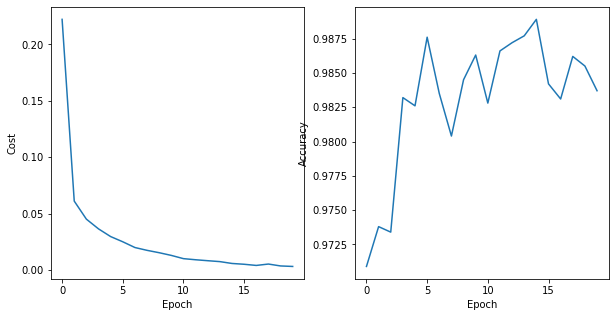

In [38]:
x = np.arange(0,training_epochs)

plt.figure(figsize=(10,5)) 
plt.subplot(1,2,1) 
plt.xlabel('Epoch') 
plt.ylabel('Cost') 
plt.plot(x,cost_list_arr) 

plt.subplot(1,2,2) 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.plot(x, accuracy_list_arr) 

plt.show()

In [92]:
import random

r = random.randint(0, len(mnist_test) - 1)
r

3390

In [72]:
X_single_data = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
Y_single_data = mnist_test.test_labels.to(device)

In [93]:
X_single_data[r]

tensor([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  90., 166., 187.,
          159., 159., 159., 102.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
     

In [95]:
Y_single_data[r]

tensor(3, device='cuda:0')

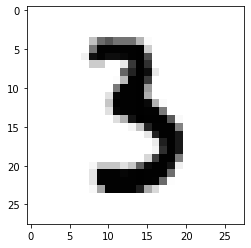

In [94]:
plt.imshow(mnist_test.test_data[r].view(28, 28), cmap='Greys', interpolation='nearest')
plt.show()

In [96]:
print('Label: ', Y_single_data[r].item())
single_prediction = model(X_single_data)
correct_prediction = torch.argmax(single_prediction, 1)
print('Prediction: ', correct_prediction[r].item())

Label:  3
Prediction:  3
